In [ ]:
import                                                                      os
import                                                                      sys
import                                                                      matplotlib
import                         numpy                as                      np
import                         pandas               as                      pd
import                         seaborn              as                      sns
import                         plotly.express       as                      px
import                         tensorflow           as                      tf
import                         matplotlib.pyplot    as                      plt
from    sklearn.preprocessing                       import                  OneHotEncoder
from    sklearn.impute                              import                  SimpleImputer
from    sklearn.preprocessing                       import                  StandardScaler,label_binarize,LabelEncoder
from    sklearn.model_selection                     import                  train_test_split
from    tensorflow.keras.layers                     import                  InputLayer,Dense,Dropout,BatchNormalization,Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D
from    tensorflow.keras.optimizers                 import                  Adam
from    tensorflow.keras.callbacks                  import                  EarlyStopping,ModelCheckpoint
from    sklearn.metrics                             import                  accuracy_score,precision_score,precision_recall_curve,roc_curve,roc_auc_score,classification_report,confusion_matrix,f1_score,average_precision_score,auc,ConfusionMatrixDisplay
from    tensorflow.keras.models                     import                  Sequential
from    tensorflow.keras.callbacks                  import                  ReduceLROnPlateau
from   xgboost                                      import                  XGBClassifier
from   sklearn.ensemble                             import                  RandomForestClassifier
from   sklearn.tree                                 import                  DecisionTreeClassifier
from   sklearn.model_selection                      import                  GridSearchCV,RandomizedSearchCV,StratifiedKFold
from   google.colab                                 import                  drive
from   tensorflow.keras.regularizers                import                  l2
from   sklearn.svm                                  import                  SVC
!pip install catboost
from   catboost                                     import                  CatBoostClassifier
drive.mount('/content/drive')
plt.rcParams["font.family"]="monospace"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.1 Reading Files

In [ ]:
df_train_X    = pd.read_csv("/content/drive/MyDrive/Fault detection/data_preprocessed/train_features_fused_unscaled (1).csv")
df_train_y    = pd.read_csv("/content/drive/MyDrive/Fault detection/data_preprocessed/train_labels.csv")
df_test_X    = pd.read_csv("/content/drive/MyDrive/Fault detection/data_preprocessed/test_features_fused_unscaled (2).csv")
df_test_y    = pd.read_csv("/content/drive/MyDrive/Fault detection/data_preprocessed/test_labels.csv")


print("X_train",df_train_X.shape)
print("y_train",df_train_y.shape)
print("X_test",df_test_X.shape)
print("y_test",df_test_y.shape)

X_train (2730, 28)
y_train (2730, 1)
X_test (1170, 28)
y_test (1170, 1)


# 2.1 Data Preprocessing

In [ ]:
Concated_train    = pd.concat([df_train_X,df_train_y],axis=1)
Concated_test     = pd.concat([df_test_X,df_test_y],axis=1)
Concated_train    = Concated_train[Concated_train["label"] != 0].reset_index(drop=True)
Concated_test     = Concated_test[Concated_test["label"] != 0].reset_index(drop=True)

In [ ]:
target_col        = "label"
input_cols_train  = [col for col in Concated_train.columns if col != target_col]
input_cols_test   = [col for col in Concated_test.columns if col != target_col]
X_train           = Concated_train[input_cols_train]
y_train           = Concated_train[[target_col]]
X_test            = Concated_test[input_cols_test]
y_test            = Concated_test[[target_col]]

In [ ]:
scaler             =   StandardScaler()
X_train_scaled     =   pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled      =   pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [ ]:
encoder                 =   OneHotEncoder(min_frequency=1,sparse_output=False)
encoded_array_train     =   encoder.fit_transform(y_train.values.reshape(-1, 1))
train_y_cols            =   encoder.get_feature_names_out(['label'])

encoded_array_test      =   encoder.transform(y_test.values.reshape(-1, 1))
test_y_cols             =   encoder.get_feature_names_out(['label'])

y_train_pick            =   pd.DataFrame(encoded_array_train,columns=train_y_cols)
y_test_pick             =   pd.DataFrame(encoded_array_test,columns=train_y_cols)


# 3.1 Model Training

## 3.1.1 Deep Learning Models

## 3.1.1.1 Ann Model

In [ ]:
ann_model = Sequential([
    InputLayer(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.30),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.30),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.30),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.30),
    Dense(12, activation="softmax")
])


optimizer = Adam(learning_rate=0.001)
earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
ann_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

ann_history = ann_model.fit(X_train_scaled, y_train_pick, epochs=1000, batch_size=64, validation_data=[X_test_scaled, y_test_pick],callbacks=[earlystopping])


os.makedirs("Models", exist_ok=True)
ann_model.save("Models/ann_model.h5")

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1443 - loss: 2.8466 - val_accuracy: 0.4000 - val_loss: 2.1194
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3312 - loss: 1.9413 - val_accuracy: 0.5130 - val_loss: 1.7849
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4439 - loss: 1.5683 - val_accuracy: 0.5963 - val_loss: 1.4474
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5233 - loss: 1.3438 - val_accuracy: 0.6083 - val_loss: 1.2047
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5567 - loss: 1.2397 - val_accuracy: 0.6435 - val_loss: 1.0248
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5925 - loss: 1.1558 - val_accuracy: 0.6620 - val_loss: 0.9011
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6049 - loss: 1.1244 - val_accuracy: 0.7111 - val_loss: 0.7872
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6146 - loss: 0.9737 - val_accurac

##  3.1.1.2 CNN model

In [ ]:

conv_model       = Sequential([
    Conv1D(filters=64,kernel_size=3,activation="relu",input_shape=(X_train_scaled.shape[1],1)),
    MaxPooling1D(pool_size=2),
    #BatchNormalization(),

    Conv1D(filters=128,kernel_size=3,activation="relu"),
    MaxPooling1D(pool_size=2),
    #BatchNormalization(),

    Conv1D(filters=256,kernel_size=3,activation="relu"),
    MaxPooling1D(pool_size=2),
    #BatchNormalization(),

    GlobalAveragePooling1D(),
    Dense(128,activation="relu"),
    #BatchNormalization(),
    Dense(64,activation="relu"),
    Dropout(0.3),
    Dense(32,activation="relu"),
    Dropout(0.3),
    Dense(12,activation="softmax")
])

optimizer_conv     = Adam(learning_rate=0.0001)
earlystopping_conv = EarlyStopping(patience=10,restore_best_weights=True,monitor="val_loss")
reduce_lr_conv     = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

conv_model.compile(loss="categorical_crossentropy",optimizer=optimizer_conv,metrics=["accuracy"])
conv_history       = conv_model.fit(X_train_scaled,y_train_pick,epochs=1000,callbacks=[earlystopping_conv,reduce_lr_conv],validation_data=[X_test_scaled,y_test_pick],batch_size=64)

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0766 - loss: 2.4829 - val_accuracy: 0.1528 - val_loss: 2.4313 - learning_rate: 1.0000e-04
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1495 - loss: 2.4197 - val_accuracy: 0.3111 - val_loss: 2.3277 - learning_rate: 1.0000e-04
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2138 - loss: 2.3143 - val_accuracy: 0.3565 - val_loss: 2.1428 - learning_rate: 1.0000e-04
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2545 - loss: 2.1851 - val_accuracy: 0.3509 - val_loss: 1.9583 - learning_rate: 1.0000e-04
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2975 - loss: 2.0576 - val_accuracy: 0.4046 - val_loss: 1.8100 - learning_rate: 1.0000e-04
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3356 - loss: 1.9500 - val_accuracy: 0.4222 - val_loss: 1.7134 - learning_rate: 1.0000e-04
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc

## 3.1.2 Machine Learning Models

## 3.1.2.1 XGBOOST Model

In [ ]:
param_grid        = {
    "eta": [0.1, 0.2],
    "gamma": [0, 0.5],
    "max_depth": [3, 6],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "lambda": [0, 1],
    "alpha": [0, 0.5],
    "max_leaves": [10, 20],
    "scale_pos_weight": [1],
    "eval_metric": ["mlogloss"],
}

cv                     = StratifiedKFold(n_splits=5)
xgb                    = XGBClassifier()
randomized_search_xgb  = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, verbose=3, random_state=42)
y_labels               = np.argmax(y_train_pick,axis=1)
randomized_search_xgb.fit(X_train_scaled, y_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.5],
                                        'colsample_bytree': [0.7, 0.8],
                                        'eta': [0.1, 0.2],
                                        'eval_metric': ['mlogloss'],
                                        'gamma': [0, 0.5], 'lambda': [0, 1],
                                        'max_depth': [3, 6],
                                        'max_leaves': [10, 20],
                                        'scale_pos_weight': [1],
                                        'subsample': [0.7, 0.8]},
                   random_state=42, scoring='accuracy', verbose=3)

## 3.1.2.2 RANDOM FOREST Model

In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15],
    "criterion": ['gini', 'entropy'],
    "bootstrap": [True],
    "max_features": ['sqrt'],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

cv = StratifiedKFold(n_splits=5)
random_forest             =   RandomForestClassifier(class_weight='balanced',random_state=42)
randomized_search_random  =   RandomizedSearchCV(estimator=random_forest,param_distributions=param_grid,n_jobs=-1,cv=cv,n_iter=30,verbose=3,scoring="f1_macro",random_state=42)
y_labels                  = np.argmax(y_train_pick,axis=1)
randomized_search_random.fit(X_train_scaled,y_labels)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='f1_macro', verbose=3)

# 3.1.2.3 SVM model


In [ ]:
y_labels    = np.argmax(y_train_pick, axis=1)

param_grid  = {
    "C": [0.1, 1, 10, 100],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1],
    "kernel": ['rbf', 'poly', 'sigmoid']
}

cv          = StratifiedKFold(n_splits=5)
svc         = SVC(class_weight='balanced', probability=True)
randomized_search_svc = RandomizedSearchCV(estimator=svc,param_distributions=param_grid,n_iter=20,scoring='f1_macro',n_jobs=-1,cv=cv,verbose=3,random_state=42)
randomized_search_svc.fit(X_train_scaled, y_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(class_weight='balanced', probability=True),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, scoring='f1_macro', verbose=3)

## 3.1.2.4 CATBOOST MODEL

In [ ]:
param_grid = {
    'iterations': [300, 500, 700],
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128]
}

cv = StratifiedKFold(n_splits=5)
randomized_search_catboost = RandomizedSearchCV(estimator=CatBoostClassifier(loss_function='MultiClass', verbose=0, random_seed=42),param_distributions=param_grid,scoring='accuracy',cv=cv,n_iter=30,n_jobs=-1,verbose=3,random_state=42)
randomized_search_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7cae679d3c50>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8],
                                        'iterations': [300, 500, 700],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.03, 0.1, 0.2]},
                   random_state=42, scoring='accuracy', verbose=3)

# 4.1 Model Evaluation (DL)

In [ ]:
def history_loss(model,history,height,width):
  fig,axes                    = plt.subplots(figsize=(width,height))
  ax=sns.lineplot(history.history["loss"],linestyle="--",linewidth=2,marker=None,color="red",label=f"Train_loss")
  ax=sns.lineplot(history.history["val_loss"],linestyle="--",linewidth=2,marker=None,color="blue",label=f"Validation_loss")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  #ax.set_title("Loss curve for Nural-Network ")
  ax.grid(True, which="major", linestyle="--",linewidth=0.7)
  ax.grid(True, which="minor", linestyle="-",linewidth=0.2)
  ax.minorticks_on()

  for spine in ax.spines.values():
    spine.set_linewidth(1.2)
  os.makedirs("Results",exist_ok=True)
  plt.savefig(f"Results/loss_{model.name}_curve.jpg",dpi=600)
  plt.show()

In [ ]:
def history_accuracy(model,history,height,width):
  fig,axes                    = plt.subplots(figsize=(width,height))
  ax_1=sns.lineplot(history.history["accuracy"],linestyle="--",linewidth=2,marker=None,color="red",label=f"Train_accuracy")
  ax_1=sns.lineplot(history.history["val_accuracy"],linestyle="--",linewidth=2,marker=None,color="blue",label=f"Validation_accuracy")
  ax_1.set_xlabel("Epochs")
  ax_1.set_ylabel("Accuracy")
  ax_1.grid(True, which="major", linestyle="--",linewidth=0.7)
  ax_1.grid(True, which="minor", linestyle="-",linewidth=0.2)
  ax_1.minorticks_on()

  for spine in ax_1.spines.values():
    spine.set_linewidth(1.2)


  os.makedirs("Results",exist_ok=True)
  plt.savefig(f"Results/accuracy_{model.name}_curve.jpg",dpi=600)
  plt.show()



#history_accuracy(ann_model,ann_history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


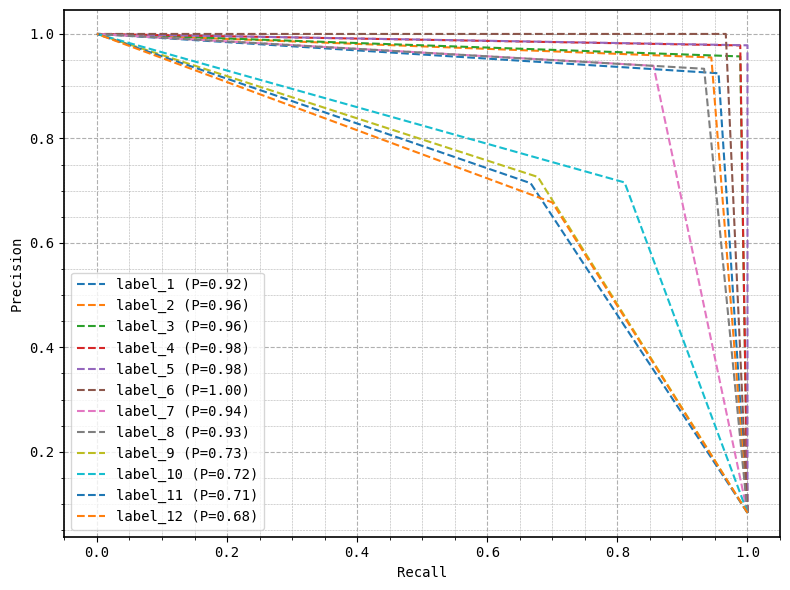

In [ ]:
def precision_recall(height,width,model):
  act                         = y_test_pick.copy()
  y_pred                      = model.predict(X_test_scaled)
  class_locations             = np.argmax(y_pred,axis=1)
  predicted_dataframe         = pd.DataFrame(np.eye((12))[class_locations])
  columns                     = [f"pred_label_{col}" for col in range(1,13)]
  predicted_dataframe.columns = columns
  act_cols                    = act.columns
  pred_cols                   = predicted_dataframe.columns
  accuracy                    = accuracy_score(act,predicted_dataframe)

  fig,axes                    = plt.subplots(figsize=(width,height))


  for i in range(12):
    y_true             = act[act_cols[i]]
    y_score            = predicted_dataframe[pred_cols[i]]
    y_pred_binary      = (y_score > 0.5).astype(int)
    class_precision    = precision_score(y_true, y_pred_binary, zero_division=0)
    precision,recall,_ = precision_recall_curve(act[act_cols[i]],predicted_dataframe[pred_cols[i]])
    plt.plot(recall,precision,label=f"{act_cols[i]} (P={class_precision:.2f})",linestyle="--")
  ax  = plt.gca()

  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

  plt.legend(loc='best')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.grid(which="major",axis="both",linestyle="--",linewidth=0.8)
  plt.grid(which="minor",axis="both",linestyle="--",linewidth=0.4)
  ax.minorticks_on()
  plt.tight_layout()
  os.makedirs("Results_final",exist_ok=True)
  plt.savefig("Results_final/Precision_recall_curve.jpg",dpi=800)
  #plt.figtext(0.5, -0.05, f"Precision Recall curve for {model}", ha="center", fontsize=12)



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


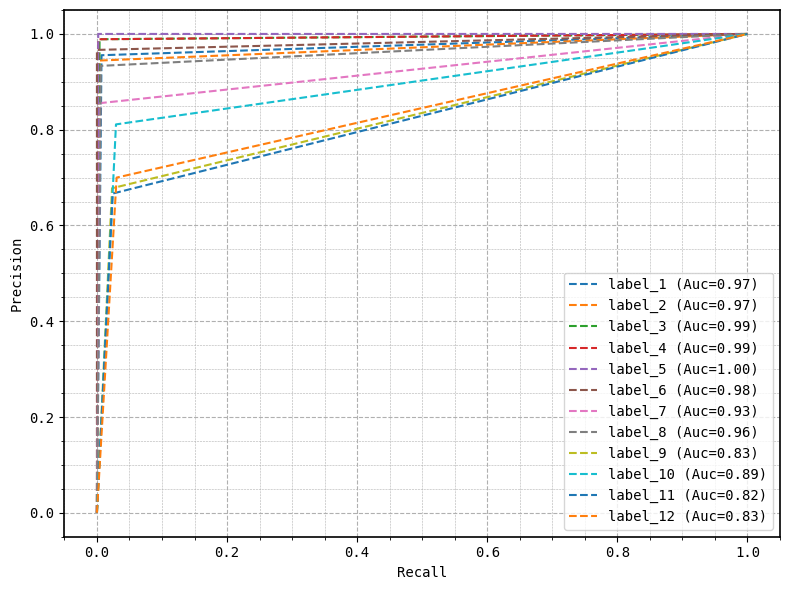

In [ ]:
def roc(height,width,model):
  act                         = y_test_pick.copy()
  y_pred                      = model.predict(X_test_scaled)
  class_locations             = np.argmax(y_pred,axis=1)
  predicted_dataframe         = pd.DataFrame(np.eye((12))[class_locations])
  columns                     = [f"pred_label_{col}" for col in range(1,13)]
  predicted_dataframe.columns = columns
  act_cols                    = act.columns
  pred_cols                   = predicted_dataframe.columns
  accuracy                    = accuracy_score(act,predicted_dataframe)

  fig,axes                    = plt.subplots(figsize=(width,height))

  for i in range(12):
    y_true             = act[act_cols[i]]
    y_score            = predicted_dataframe[pred_cols[i]]
    y_pred_binary      = (y_score > 0.5).astype(int)
    class_roc          = roc_auc_score(y_true, y_pred_binary)

    fpr, tpr, _        = roc_curve(act[act_cols[i]],predicted_dataframe[pred_cols[i]])
    plt.plot(fpr,tpr,label=f"{act_cols[i]} (Auc={class_roc:.2f})",linestyle="--")


  ax  = plt.gca()

  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

  plt.legend(loc='best')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.grid(which="major",axis="both",linestyle="--",linewidth=0.8)
  plt.grid(which="minor",axis="both",linestyle="--",linewidth=0.4)
  ax.minorticks_on()
  plt.tight_layout()
  os.makedirs("Results_final",exist_ok=True)
  plt.savefig("Results_final/roc_curve.jpg",dpi=800)
  #plt.figtext(0.5, -0.05, f"Precision Recall curve for {model}", ha="center", fontsize=12)



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


<Figure size 2600x600 with 0 Axes>

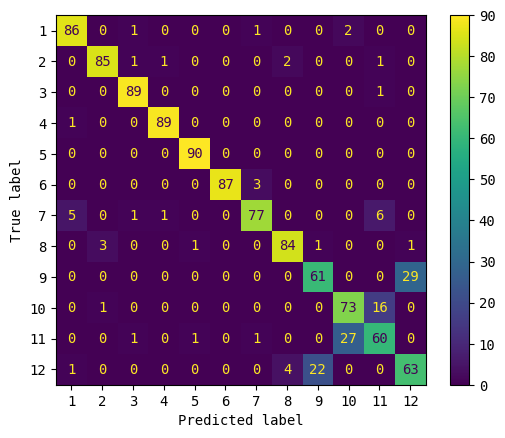

In [ ]:
def confusion_matrix_nural(model,y_test_encoded,X_test,width,height):
  y_pred                      = model.predict(X_test)
  y_pred_classes              = np.argmax(y_pred, axis=1)+1
  y_true_classes              = np.argmax(y_test_encoded.copy(), axis=1)+1
  confusion_mat               = confusion_matrix(y_true_classes,y_pred_classes)
  plt.figure(figsize=(26, 6))
  disp                        = ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

  os.makedirs("Results_final",exist_ok=True)
  plt.savefig(f"Results_final/confusion_matrix_{model.name}_curve.jpg",dpi=800)
  plt.show()



# 4.2 Model evaluation (ML)

0.787962962962963


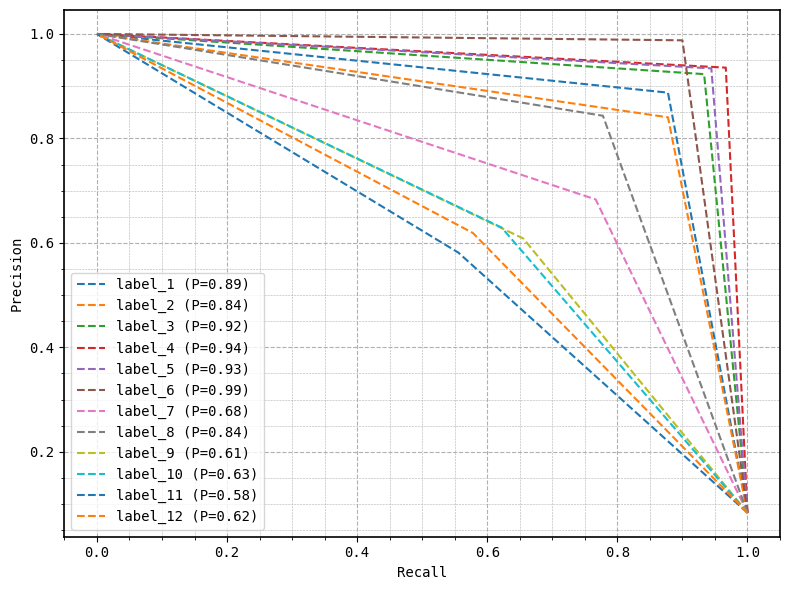

In [ ]:
def precision_recall_ml(height,width,model_name,model):

  prediction                = model.predict(X_test_scaled)
  y_test_labels             = np.argmax(y_test_pick,axis=1)
  predicted_df              = pd.DataFrame(np.eye(12)[prediction])
  columns                   = [f"pred_label_{col}" for col in range(1,13)]
  predicted_df.columns      = columns
  print(accuracy_score(y_test_pick,predicted_df))
  act=y_test_pick.copy()
  act_cols                  = act.columns
  pred_cols                 = predicted_df.columns
  accuracy                  = accuracy_score(act,predicted_df)

  fig,axes                  = plt.subplots(figsize=(width,height))


  for i in range(12):
    y_true             = act[act_cols[i]]
    y_score            = predicted_df[pred_cols[i]]
    y_pred_binary      = (y_score > 0.5).astype(int)
    class_precision    = precision_score(y_true, y_pred_binary, zero_division=0)
    precision,recall,_ = precision_recall_curve(act[act_cols[i]],predicted_df[pred_cols[i]])
    plt.plot(recall,precision,label=f"{act_cols[i]} (P={class_precision:.2f})",linestyle="--")
  ax  = plt.gca()

  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

  plt.legend(loc='best')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.grid(which="major",axis="both",linestyle="--",linewidth=0.8)
  plt.grid(which="minor",axis="both",linestyle="--",linewidth=0.4)
  ax.minorticks_on()
  plt.tight_layout()
  os.makedirs("Results_final",exist_ok=True)
  plt.savefig(f"Results_final/Precision_recall_curve{model_name}.jpg",dpi=800)
  #plt.figtext(0.5, -0.05, f"Precision Recall curve for {model}", ha="center", fontsize=12)
model_name="xgboost"


In [ ]:
def roc_ml(height,width,model_name,model):

  prediction              = model.predict(X_test_scaled)
  y_test_labels           = np.argmax(y_test_pick,axis=1)
  predicted_df            = pd.DataFrame(np.eye(12)[prediction])
  columns                 = [f"pred_label_{col}" for col in range(1,13)]
  predicted_df.columns    = columns
  print(accuracy_score(y_test_pick,predicted_df))
  act=y_test_pick.copy()
  act_cols                = act.columns
  pred_cols               = predicted_df.columns
  accuracy                = accuracy_score(act,predicted_df)

  fig,axes                = plt.subplots(figsize=(width,height))


  for i in range(12):
    y_true             = act[act_cols[i]]
    y_score            = predicted_df[pred_cols[i]]
    y_pred_binary      = (y_score > 0.5).astype(int)
    class_roc          = roc_auc_score(y_true, y_pred_binary)
    fpr, tpr,_         = roc_curve(act[act_cols[i]],predicted_df[pred_cols[i]])


    plt.plot(fpr, tpr,label=f"{act_cols[i]} Auc {class_roc:.2f}",linestyle="--")
  ax  = plt.gca()

  for spine in ax.spines.values():
    spine.set_linewidth(1.2)

  plt.legend(loc='best')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.grid(which="major",axis="both",linestyle="--",linewidth=0.8)
  plt.grid(which="minor",axis="both",linestyle="--",linewidth=0.4)
  ax.minorticks_on()
  plt.tight_layout()
  os.makedirs("Results_final",exist_ok=True)
  plt.savefig(f"Results_final/Precision_recall_curve{model_name}jpg",dpi=800)
  #plt.figtext(0.5, -0.05, f"Precision Recall curve for {model}", ha="center", fontsize=12)
model_name="xgboost"


<Figure size 600x800 with 0 Axes>

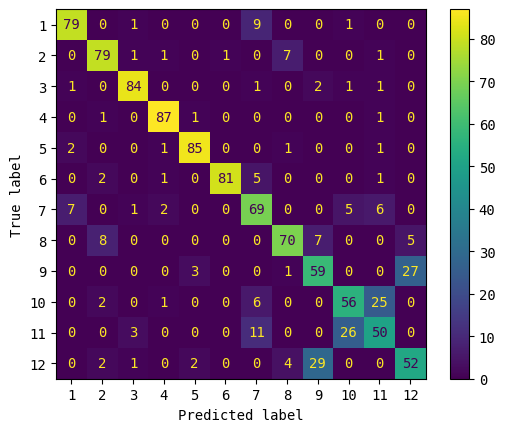

In [ ]:
def confusion_matrix_ml(model, y_test_encoded, X_test, width, height):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred + 1
    y_true_classes = np.argmax(y_test_encoded.copy(), axis=1) + 1
    plt.figure(figsize=(width, height))
    disp = ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)
    os.makedirs("Results_final", exist_ok=True)
    plt.savefig(f"Results_final/confusion_matrix_{model.__class__.__name__}_curve.jpg", dpi=800)
    plt.show()



# 5.1 Final Model Evaluation(DL)

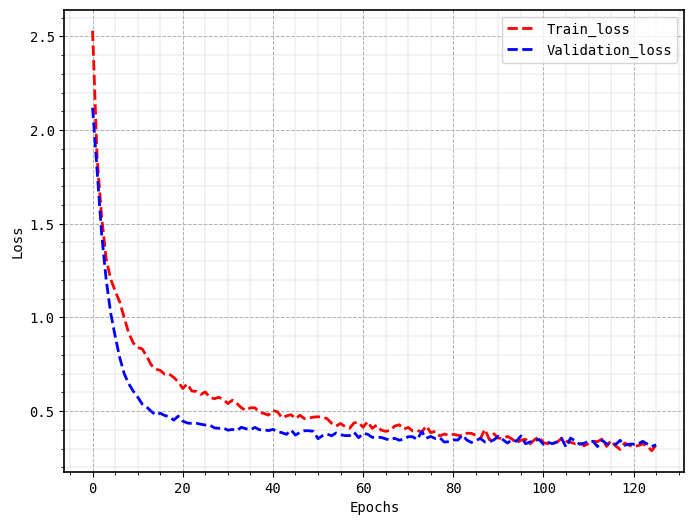

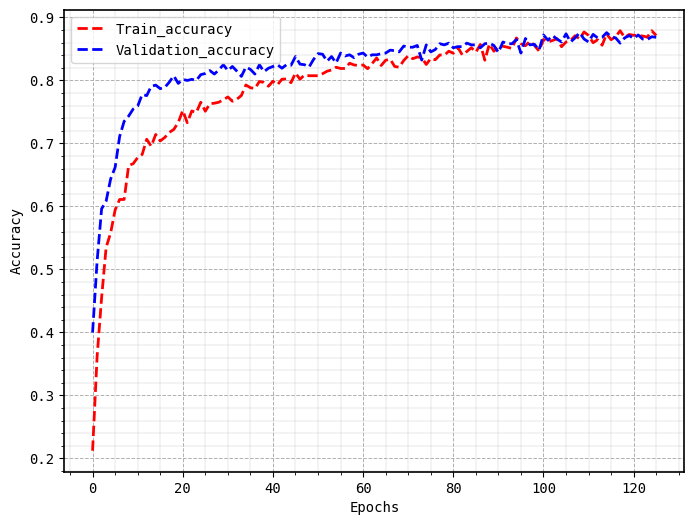

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


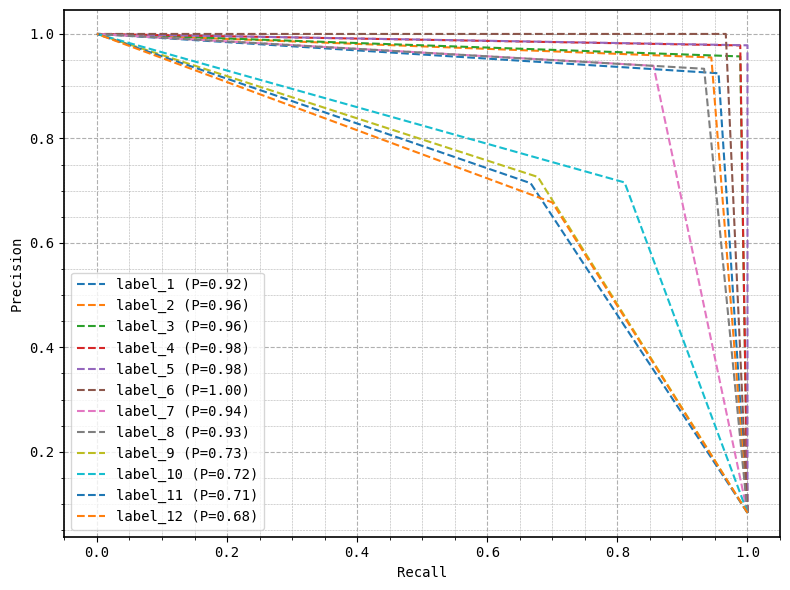

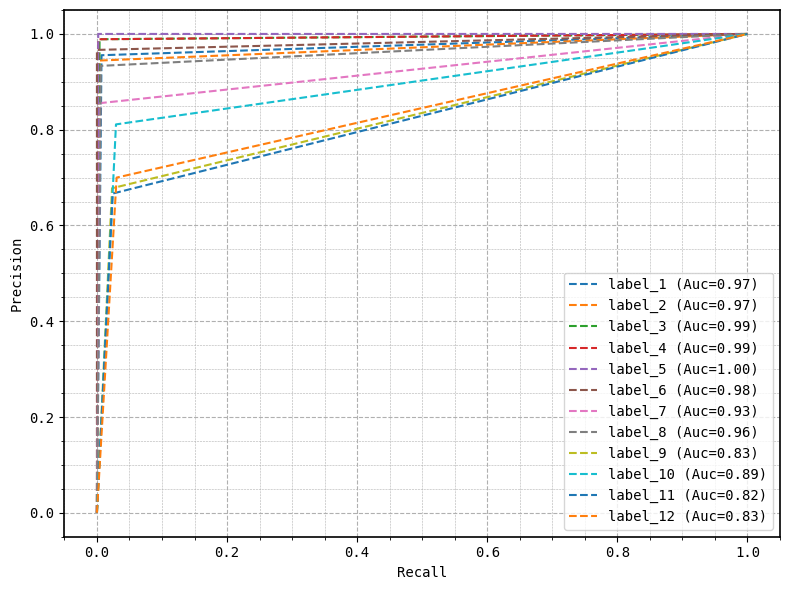

<Figure size 2600x600 with 0 Axes>

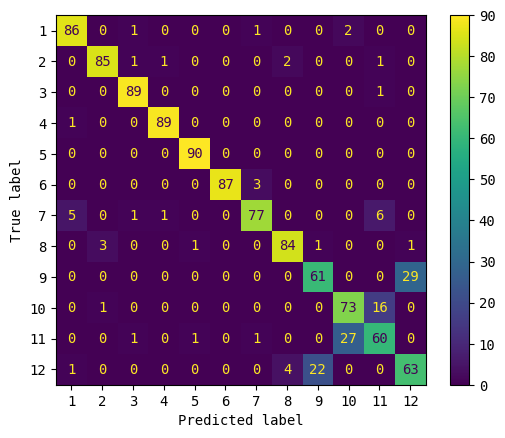

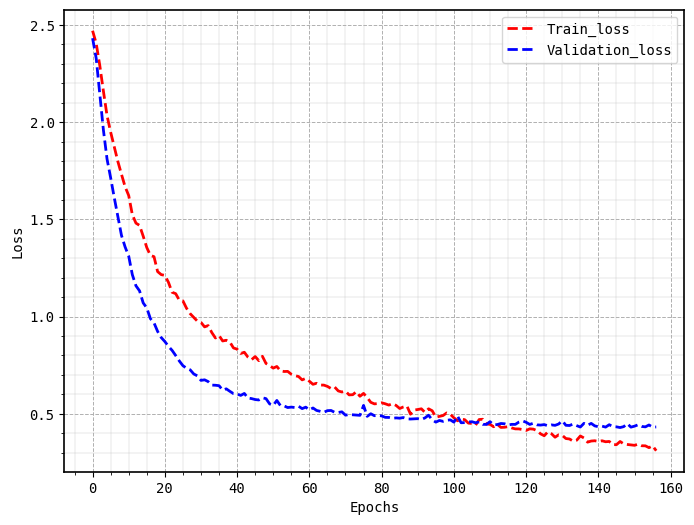

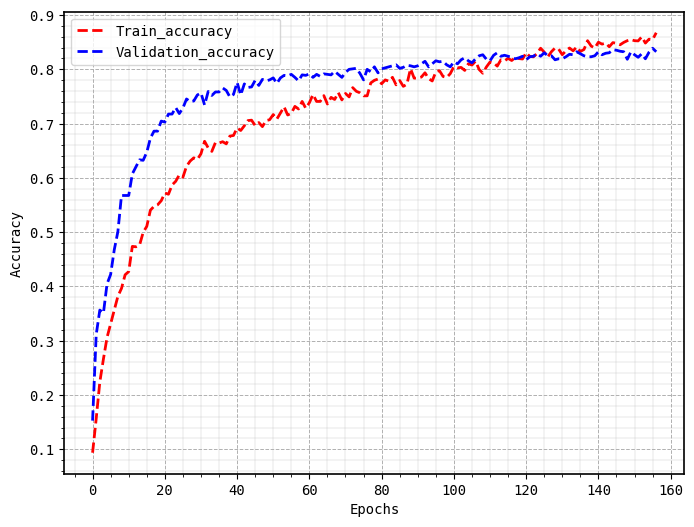

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


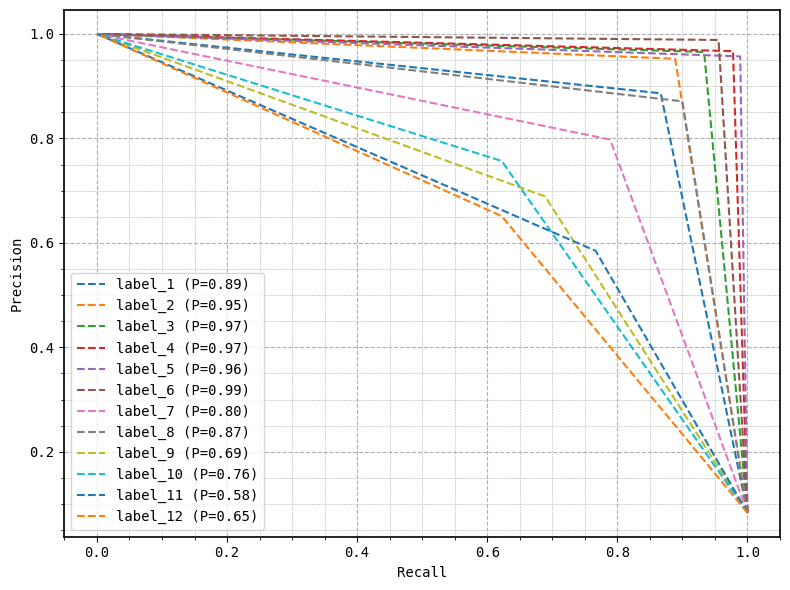

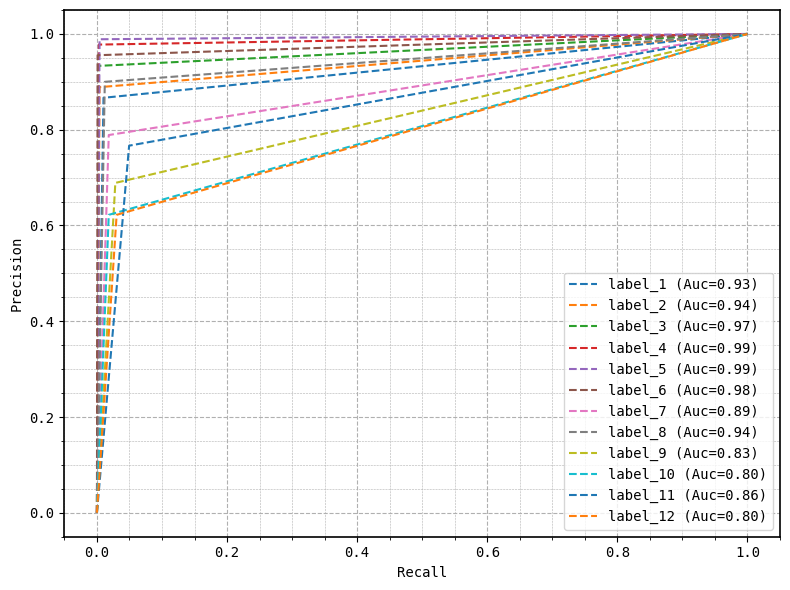

<Figure size 2600x600 with 0 Axes>

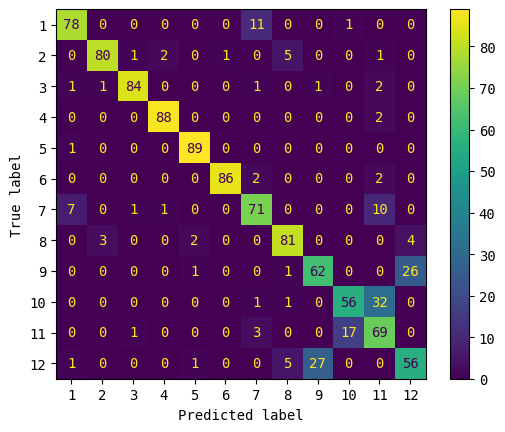

In [ ]:
nural_model_names= [ann_model,conv_model]
nural_history    = [ann_history,conv_history]
height=6
width=8
for model,history in zip(nural_model_names,nural_history):
  history_loss(model,history,height,width)
  history_accuracy(model,history,height,width)
  precision_recall(height,width,model)
  roc(height,width,model)
  confusion_matrix_nural(model,y_test_pick,X_test_scaled,width,height)

# Final model evaluation(ML)

0.787962962962963
0.787962962962963


KeyboardInterrupt: 

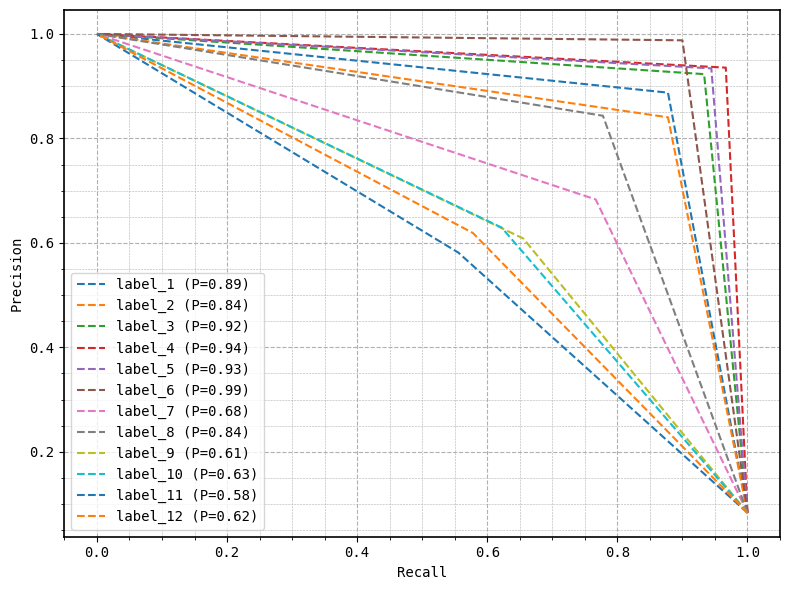

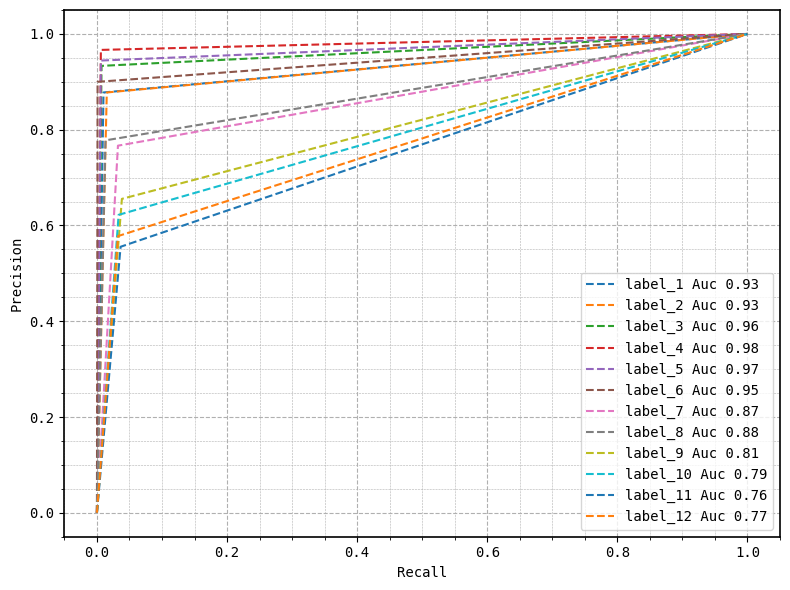

<Figure size 600x800 with 0 Axes>

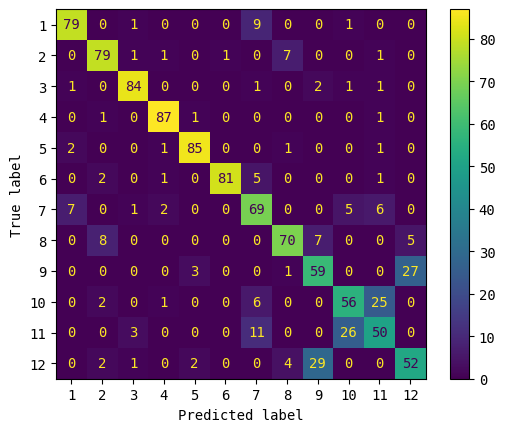

In [ ]:

model_names = [randomized_search_xgb,randomized_search_random,randomized_search_svc,randomized_search_catboost]
model_      = ["xgboost","random forest","SVM","Catboost"]
for main_model,model in zip(model_names,model_):
  precision_recall_ml(6,8,model,main_model)
  roc_ml(6,8,model,main_model)
  confusion_matrix_ml(main_model, y_test_pick, X_test_scaled,6, 8)

In [ ]:
model="catboost"
main_model=randomized_search_catboost

<Figure size 600x800 with 0 Axes>

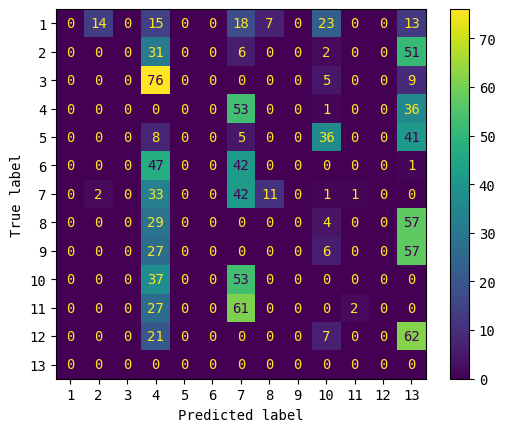

In [ ]:

confusion_matrix_ml(main_model, y_test_pick, X_test_scaled,6, 8)